# **Chapter 10**
## *Building Univariate Time Series Models Using Statistical Methods*, 

This chapter kick offs the journey into modeling and forecasting time series. The chapter intuitively explains what autocorrelation function (ACF) and partial autocorrelation function (PACF) plots are and how they are used, and then moves in to training, diagnosing, and comparing different models, including exponential smoothing, autoregressive integrated moving average (ARIMA), and seasonal ARIMA (SARIMA). Additionally, this chapter introduces grid search and hyperparameter tuning.

In this chapter, we will cover the following recipes:
* Plotting ACF and PACF
* Forecasting univariate time series data with exponential smoothing
* Forecasting univariate time series data with non-seasonal ARIMA
* Forecasting univariate time series data with seasonal ARIMA

Before diving into these recipes, pay special attention to the upcoming Technical requirements section, in which you will perform upfront preparation. This will remove any distractions and repetitive coding so that you can focus on the recipe's core goals and the concepts behind each implementation.

# ---START: Technical Requirements---


In [1]:
import statsmodels
statsmodels.__version__

'0.14.4'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from statsmodels.tsa.api import (kpss, adfuller, 
                                 seasonal_decompose, STL)
from statsmodels.tools.eval_measures import rmspe, rmse
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
import statsmodels as sm
from pathlib import Path


warnings.filterwarnings('ignore')

In [5]:
###### configurations for image quality#######
plt.rcParams["figure.figsize"] = [12, 5]   ##
#plt.rcParams['figure.dpi'] = 100          ## use 300 for printing
plt.rc('font', size=8)                     ## 
plt.rc('axes', titlesize=14)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 
#############################################

In [7]:
import matplotlib 
import scipy 
import sklearn

print(f'''
Matplotlib -> {matplotlib.__version__}
pandas -> {pd.__version__}   
numpy -> {np.__version__}
scipy -> {scipy.__version__}
statsmodels -> {sm.__version__}
sklearn -> {sklearn.__version__}
''')


Matplotlib -> 3.9.2
pandas -> 2.2.3   
numpy -> 1.26.4
scipy -> 1.11.4
statsmodels -> 0.14.4
sklearn -> 1.5.2



In [9]:
life_file = ('https://raw.githubusercontent.com/PacktPublishing/Time-Series-Analysis-with-Python-Cookbook/refs/heads/main/datasets/Ch10/life_expectancy_birth.csv')
milk_file = ('https://raw.githubusercontent.com/PacktPublishing/Time-Series-Analysis-with-Python-Cookbook/refs/heads/main/datasets/Ch10/milk_production.csv')

life = pd.read_csv(life_file, 
                   index_col='year',
                   parse_dates=True,
                   skipfooter=1)

milk = pd.read_csv(milk_file, 
                   index_col='month', 
                   parse_dates=True)

In [11]:
life.shape

(59, 1)

In [13]:
milk.shape

(168, 1)

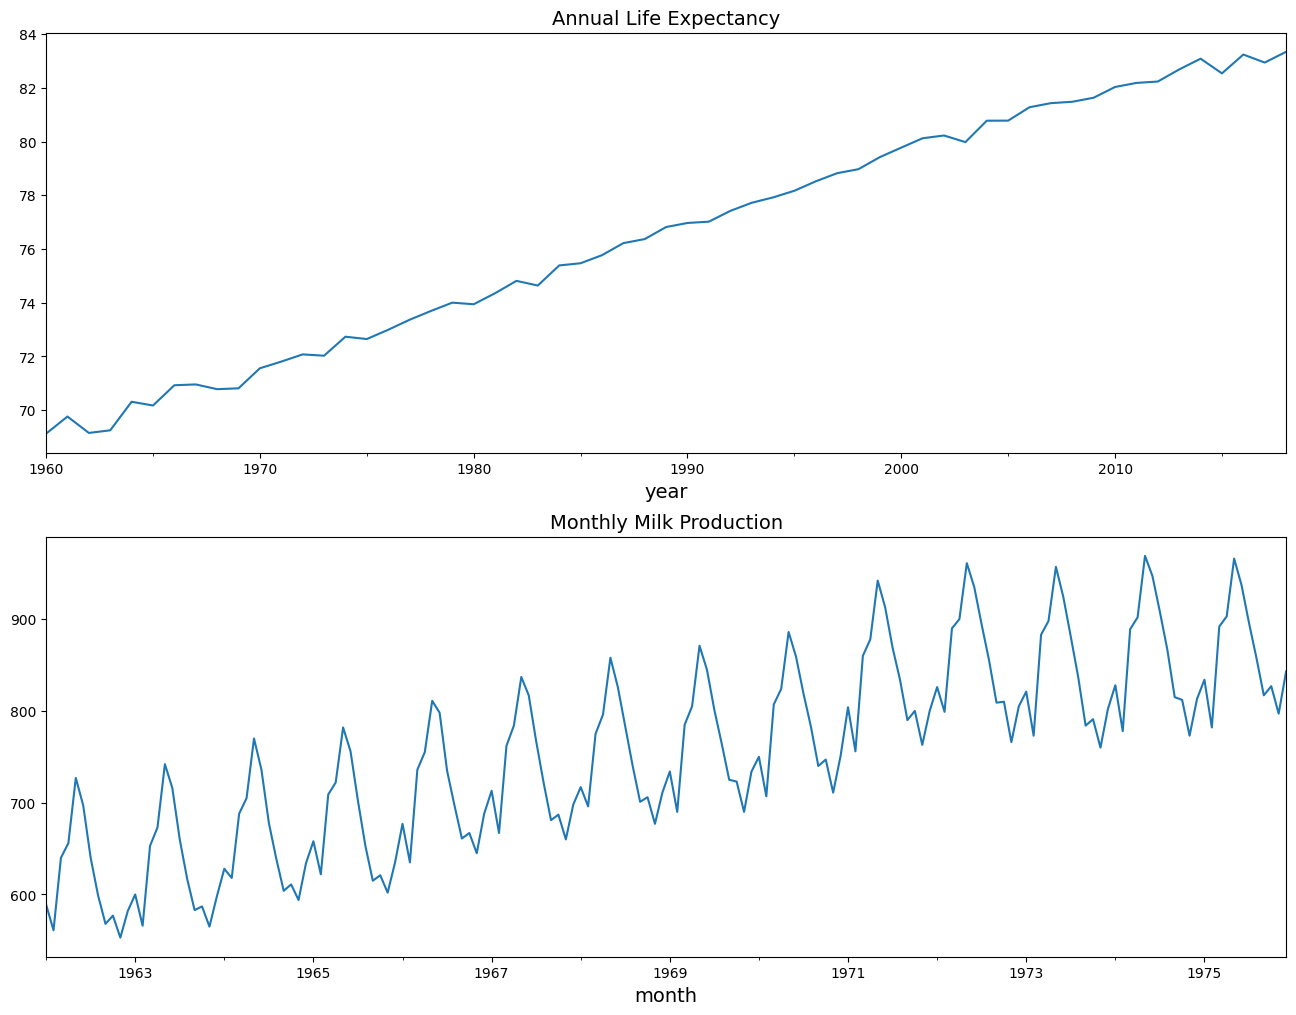

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(16, 12))

life.plot(title='Annual Life Expectancy', 
                        legend=False, ax=ax[0])
milk.plot(title='Monthly Milk Production', 
                        legend=False, ax=ax[1]);

# plt.savefig('images/fig_10.1.png', bbox_inches='tight', dpi=300)

In [17]:
def split_data(data, test_split):
    
    l = len(data)                                     # Get the total length of the dataset
    t_idx = round(l * (1 - test_split))               # Compute the index for splitting
    train, test = data[:t_idx], data[t_idx:]          # Split data into train and test sets
    print(f'train: {len(train)} , test: {len(test)}') # Print the sizes of the splits
    
    return train, test                                # Return the train and test sets

In [19]:
test_split = 0.15

milk_train, milk_test = split_data(milk, test_split)
life_train, life_test = split_data(life, test_split)

train: 143 , test: 25
train: 50 , test: 9


In [21]:
def check_stationarity(df):
    
    results = adfuller(df)[1:3]  # Extract p-value and number of lags from ADF test
    s = 'Non-Stationary'         # Default assumption: non-stationary data
    if results[0] < 0.05:        # Check if p-value is less than significance level (0.05)
        s = 'Stationary'         # If p-value < 0.05, reject null hypothesis -> data is stationary
    print(f"'{s}\t p-value:{results[0]} \t lags:{results[1]}") # Display results
    
    return (s, results[0])       # Return stationarity status and p-value

In [23]:
def get_best_model(score, c='AIC'):
    
    initial_score = score[0][c]        # Initialize with the first model's score
    best_model = 0                     # Track the index of the best model
    for k, v in score.items():         # Iterate over the models
        if v[c] < initial_score:       # Check if the current model has a lower score
            initial_score = v[c]       # Update the lowest score
            best_model = k             # Update the best model index
    print(f'Best model: {best_model} with lowest {c} score: {initial_score}')  # Display best model
    
    return score[best_model]['model']  # Return the best model

In [25]:
def plot_forecast(model, start, train, test):
    
    # Generate forecasted values for the test set
    forecast = pd.DataFrame(model.forecast(test.shape[0]), 
                            index=test.index)  
    
    ax = train.loc[start:].plot(style='--')  # Plot training data with dashed lines
    test.plot(ax=ax)                         # Plot test data
    forecast.plot(ax=ax, style='-.')         # Plot forecasted data with dash-dot lines
    ax.legend(['orig_train', 'orig_test', 'forecast'])  # Add legend for clarity
    
    # plt.show()                             # Optional: Uncomment to display the plot immediately
    return ax                                # Return the axis object for further customization

In [27]:
def combinator(items, r=1):
    
    combo = [i for i in product(*items, repeat=r)]  # Generate Cartesian product of input lists
    
    return combo                                    # Return the list of combinations

# Recipe 1. Plotting ACF and PACF

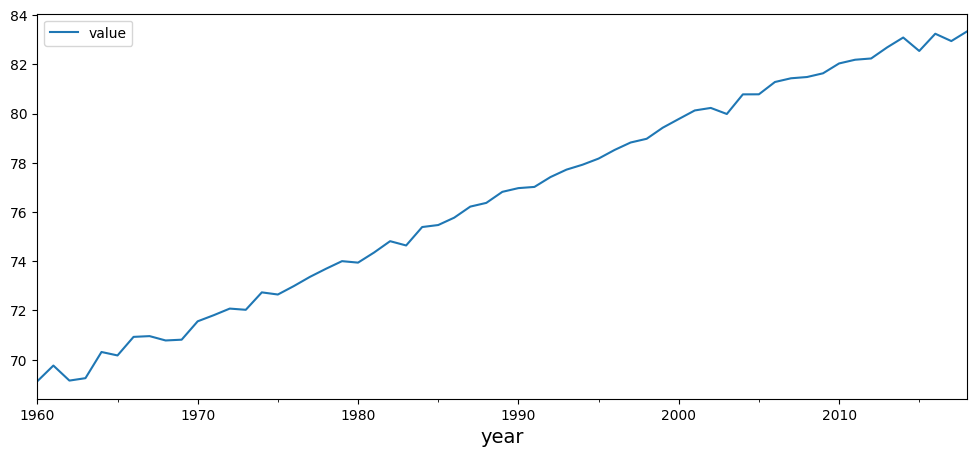

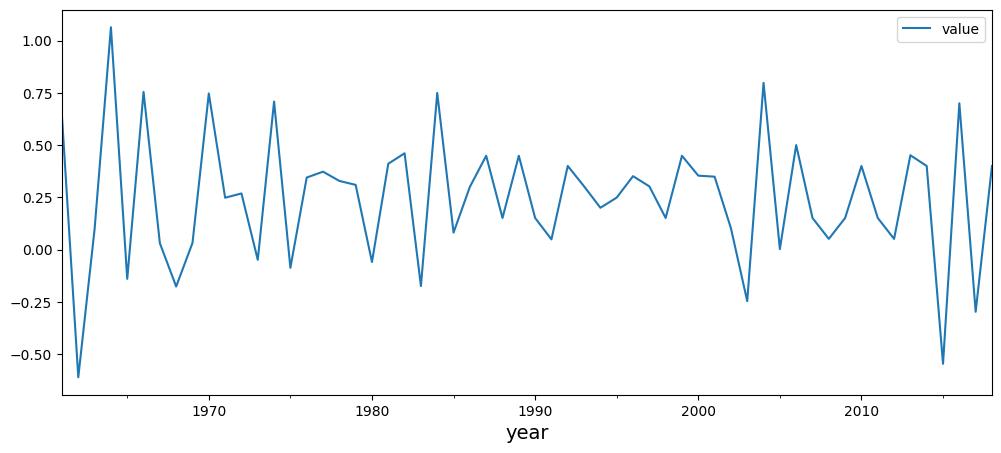

In [31]:
# plt.rcParams["figure.figsize"] = [16, 4]
life.plot();
life_diff = life.diff().dropna()
life_diff.plot();

In [41]:
check_stationarity(life_diff);

'Stationary	 p-value:1.556218967600307e-14 	 lags:1


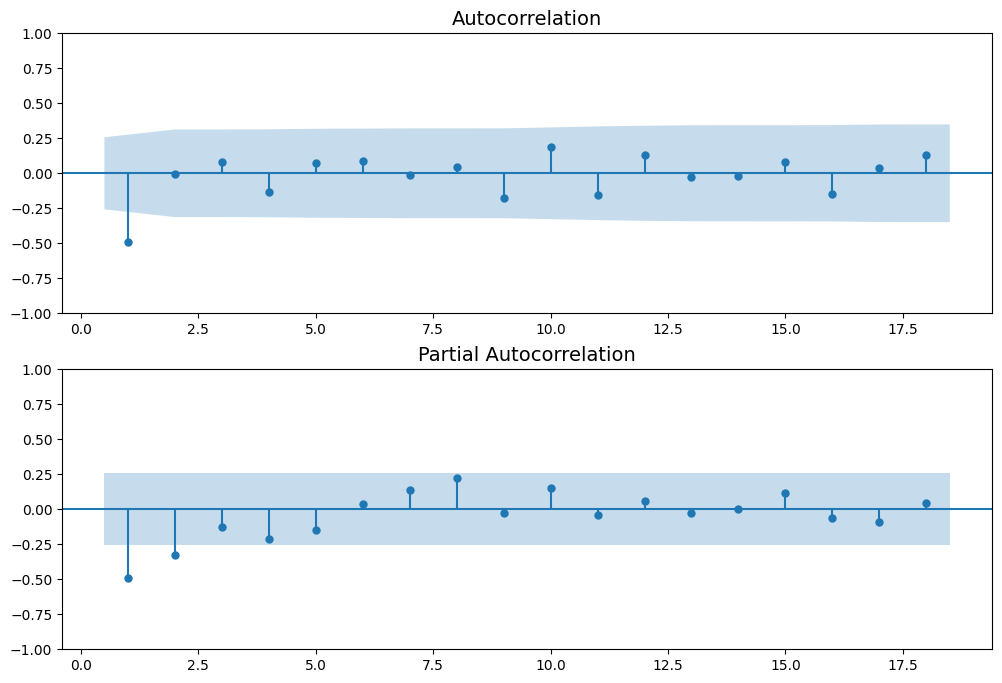

In [43]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(life_diff, zero=False, ax=ax[0])
plot_pacf(life_diff, zero=False, ax=ax[1])
plt.show()

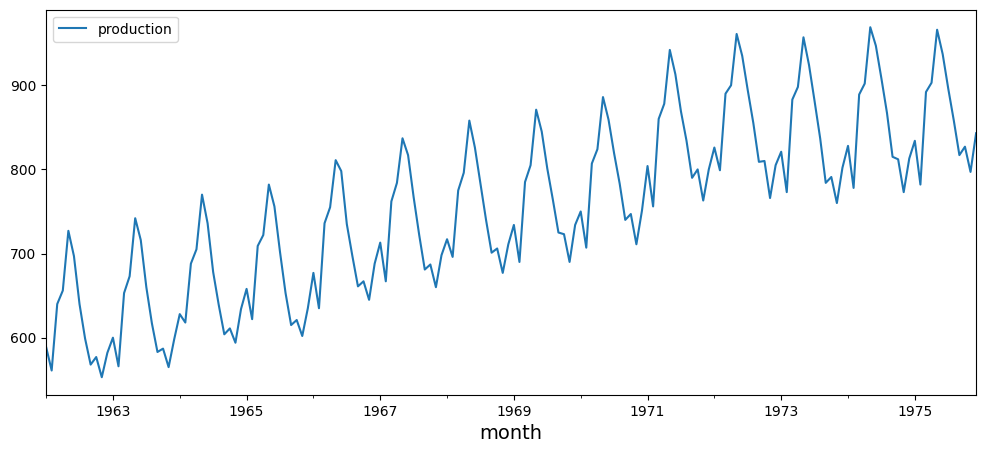

In [45]:
milk.plot();

In [49]:
# Compute the 12-month differenced series to remove seasonality
milk_diff_12 = milk.diff(12).dropna()

In [53]:
check_stationarity(milk_diff_12);

'Non-Stationary	 p-value:0.16079880527711288 	 lags:12


In [55]:
milk_diff_12_1 = milk.diff(12).diff(1).dropna() #<====== !!!!!

check_stationarity(milk_diff_12_1);

'Stationary	 p-value:1.865423431878764e-05 	 lags:11


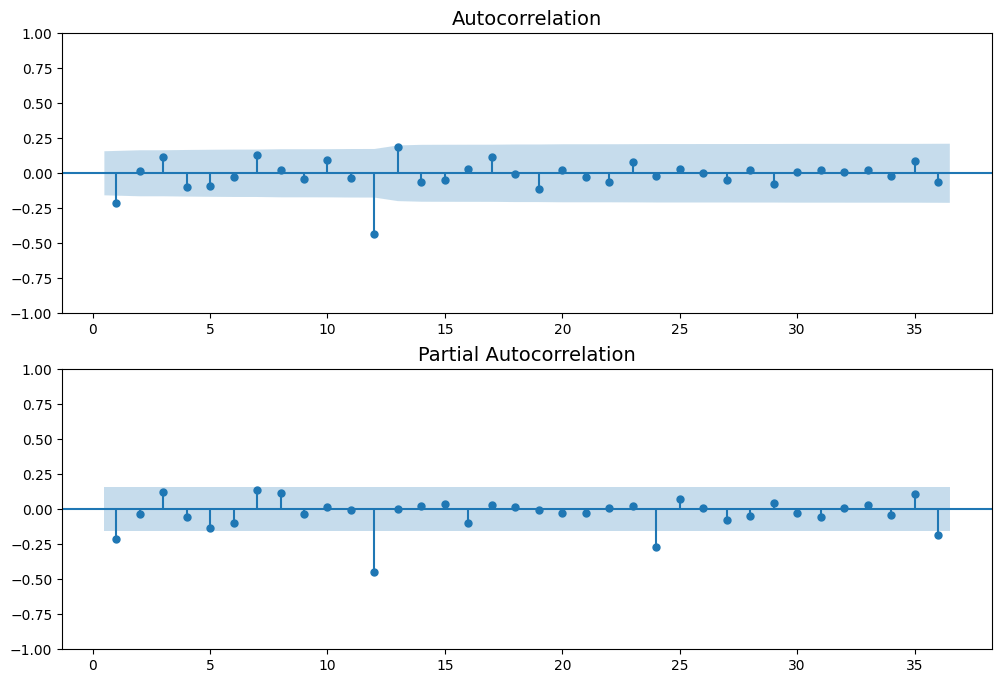

In [57]:
fig, ax = plt.subplots(2,1, figsize=(12,8))

plot_acf(milk_diff_12_1, zero=False, ax=ax[0], lags=36)
plot_pacf(milk_diff_12_1, zero=False, ax=ax[1], lags=36)

plt.show()

## SARIMAX

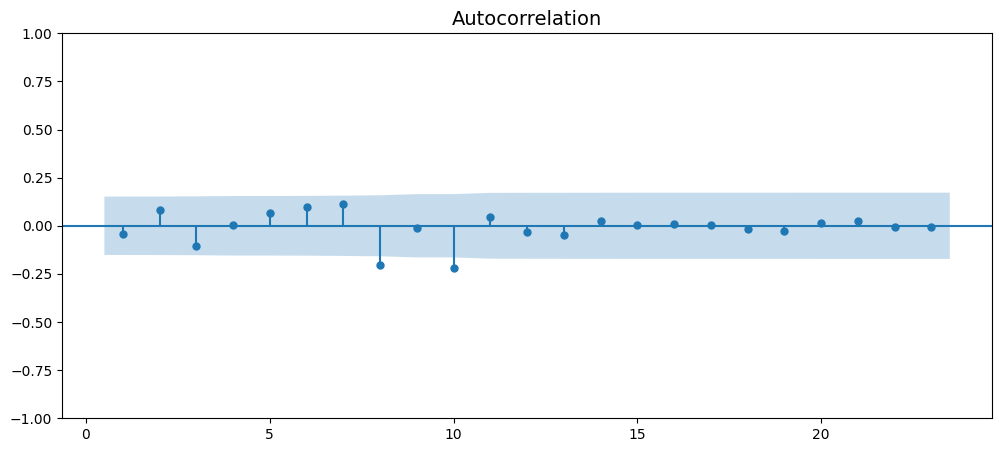

In [60]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(milk, order=(0,1,1),
                seasonal_order=(0,1,1, 12)).fit(disp=False)

plot_acf(model.resid[1:], zero=False)

plt.show()

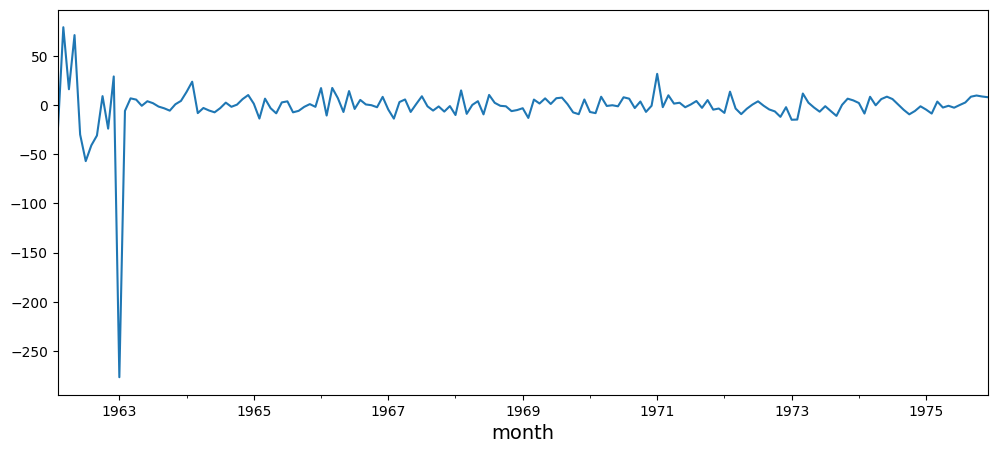

In [62]:
model.resid[1:].plot();

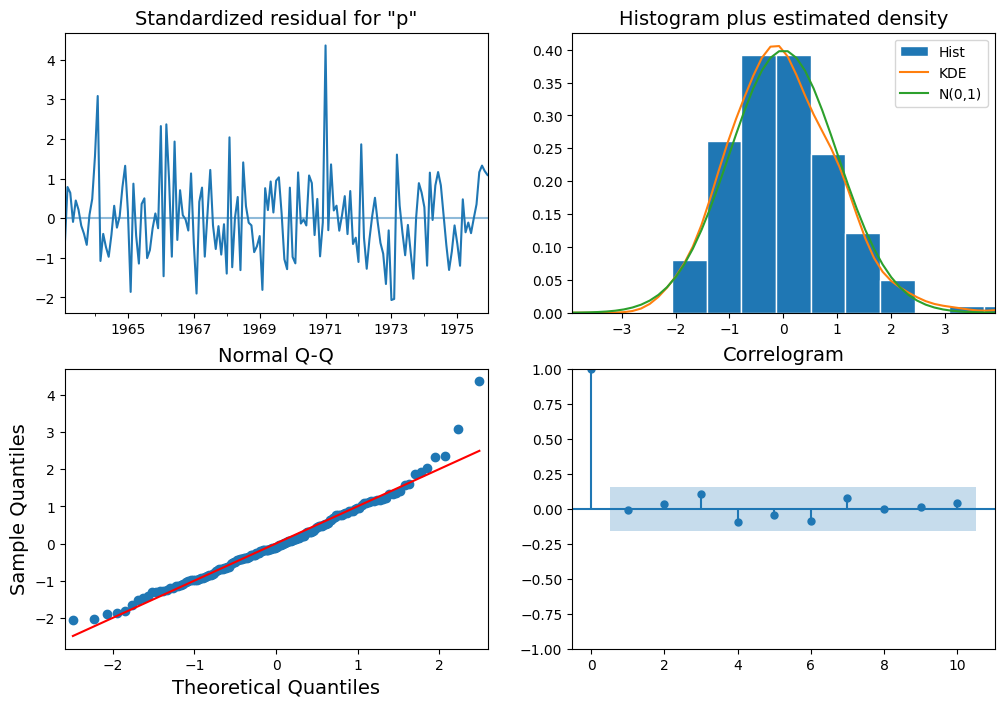

In [66]:
model.plot_diagnostics(figsize=(12, 8))
plt.show();

In [68]:
# Extract residuals from the model, excluding the first observation
model.resid[1:]  

month
1962-02-01   -27.995259
1962-03-01    78.999549
1962-04-01    16.001272
1962-05-01    71.000258
1962-06-01   -29.998857
                ...    
1975-08-01     2.556263
1975-09-01     8.435671
1975-10-01     9.640234
1975-11-01     8.624987
1975-12-01     7.918949
Length: 167, dtype: float64

In [72]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(model.resid, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals

All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.



,lb_stat,lb_pvalue
1,0.340295,0.559659
2,2.995650,0.223616
3,2.995795,0.392274
4,4.629365,0.327483
5,4.703891,0.453075
6,5.114835,0.529171
7,5.220309,0.633098
8,6.518364,0.589371
9,6.540064,0.684883
10,7.696060,0.658498


# Recipe 2. Forecasting Univariate Time Series Data with Exponential Smoothing

In [74]:
from statsmodels.tsa.api import ExponentialSmoothing

In [78]:
trend = ['add', 'mul']
damped = [True, False]

life_ex_comb = combinator([trend, damped])
life_ex_comb

[('add', True), ('add', False), ('mul', True), ('mul', False)]

In [80]:
# Flatten training and testing data into one-dimensional arrays
train = life_train.values.ravel()  # Convert training data to a 1D array
y = life_test.values.ravel()       # Convert testing data to a 1D array

score = {}  # Initialize an empty dictionary to store model evaluation metrics

# Iterate over each combination of trend and damped trend in life_ex_comb
for i, (t, dp) in enumerate(life_ex_comb):
    
    # Initialize the Exponential Smoothing model with specified parameters
    exp = ExponentialSmoothing(train, 
                               trend=t,         # Set the trend component
                               damped_trend=dp, # Apply damping if applicable
                               seasonal=None)   # No seasonal component
    
    # Fit the model using brute force optimization
    model = exp.fit(use_brute=True, optimized=True)   
    
    # Forecast the length of the test set
    y_hat = model.forecast(len(y))
    
    # Store evaluation metrics and model in the score dictionary
    score[i] = {'trend': t,               # Trend type used in the model
                'damped': dp,             # Whether damping was applied
                'AIC': model.aic,         # Akaike Information Criterion
                'BIC': model.bic,         # Bayesian Information Criterion
                'AICc': model.aicc,       # Corrected Akaike Information Criterion
                'RMSPE': rmspe(y, y_hat), # Root Mean Squared Percentage Error
                'RMSE': rmse(y, y_hat),   # Root Mean Squared Error
                'MAPE': mape(y, y_hat),   # Mean Absolute Percentage Error
                'model': model}           # Store the trained model

In [82]:
life_best_model = get_best_model(score, 'AIC')

Best model: 1 with lowest AIC score: -137.0306017750196


In [84]:
life_best_model.summary()

Dep. Variable:,endog,No. Observations:,50
Model:,ExponentialSmoothing,SSE,2.749
Optimized:,True,AIC,-137.031
Trend:,Additive,BIC,-129.383
Seasonal:,None,AICC,-135.077
Seasonal Periods:,None,Date:,"Thu, 20 Mar 2025"
Box-Cox:,False,Time:,12:21:38
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1621957,alpha,True
smoothing_trend,0.1621957,beta,True


In [86]:
life_best_model.params_formatted

,name,param,optimized
smoothing_level,alpha,0.162196,True
smoothing_trend,beta,0.162196,True
initial_level,l.0,68.748482,True
initial_trend,b.0,0.242227,True


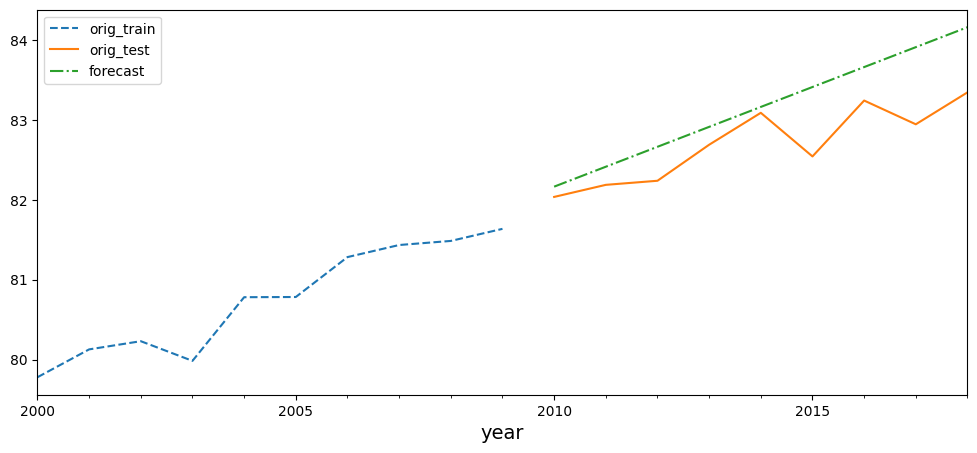

In [90]:
plot_forecast(life_best_model, '2000', life_train, life_test);

In [92]:
trend , damped= ['add', 'mul'], [True, False] 
seasonal, periods = ['add' , 'mul'], [4, 6, 12]

milk_exp_comb = combinator([trend, damped, seasonal, periods])
milk_exp_comb

[('add', True, 'add', 4),
 ('add', True, 'add', 6),
 ('add', True, 'add', 12),
 ('add', True, 'mul', 4),
 ('add', True, 'mul', 6),
 ('add', True, 'mul', 12),
 ('add', False, 'add', 4),
 ('add', False, 'add', 6),
 ('add', False, 'add', 12),
 ('add', False, 'mul', 4),
 ('add', False, 'mul', 6),
 ('add', False, 'mul', 12),
 ('mul', True, 'add', 4),
 ('mul', True, 'add', 6),
 ('mul', True, 'add', 12),
 ('mul', True, 'mul', 4),
 ('mul', True, 'mul', 6),
 ('mul', True, 'mul', 12),
 ('mul', False, 'add', 4),
 ('mul', False, 'add', 6),
 ('mul', False, 'add', 12),
 ('mul', False, 'mul', 4),
 ('mul', False, 'mul', 6),
 ('mul', False, 'mul', 12)]

In [94]:
len(milk_exp_comb)

24

In [96]:
# Flatten training and testing data into one-dimensional arrays
train = milk_train.values.ravel()  # Convert training data to a 1D array
y = milk_test.values.ravel()       # Convert testing data to a 1D array

milk_model_scores = {}  # Initialize an empty dictionary to store model evaluation metrics

# Iterate over each combination of trend, damped trend, seasonality, and seasonal periods
for i, (t, dp, s, sp) in enumerate(milk_exp_comb):
    
    # Initialize the Exponential Smoothing model with specified parameters
    exp = ExponentialSmoothing(train, 
                               trend=t,              # Set the trend component
                               damped_trend=dp,      # Apply damping if applicable
                               seasonal=s,           # Define seasonal component
                               seasonal_periods=sp)  # Set seasonal periodicity
    
    # Fit the model using brute force optimization
    model = exp.fit(use_brute=True, optimized=True)  
    
    # Forecast the length of the test set
    y_hat = model.forecast(len(y))
    
    # Store evaluation metrics and model in the dictionary
    milk_model_scores[i] = {'trend': t,                # Trend type used in the model
                            'damped': dp,              # Whether damping was applied
                            'AIC': model.aic,          # Akaike Information Criterion
                            'BIC': model.bic,          # Bayesian Information Criterion
                            'AICc': model.aicc,        # Corrected Akaike Information Criterion
                            'RMSPE': rmspe(y, y_hat),  # Root Mean Squared Percentage Error
                            'RMSE': rmse(y, y_hat),    # Root Mean Squared Error
                            'MAPE': mape(y, y_hat),    # Mean Absolute Percentage Error
                            'model': model}            # Store the trained model

In [97]:
milk_model = get_best_model(milk_model_scores)

Best model: 8 with lowest AIC score: 593.7138789369326


In [100]:
milk_model.summary()

Dep. Variable:,endog,No. Observations:,143
Model:,ExponentialSmoothing,SSE,7265.655
Optimized:,True,AIC,593.714
Trend:,Additive,BIC,641.119
Seasonal:,Additive,AICC,599.230
Seasonal Periods:,12,Date:,"Thu, 20 Mar 2025"
Box-Cox:,False,Time:,13:51:05
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6859134,alpha,True
smoothing_trend,6.2261e-11,beta,True


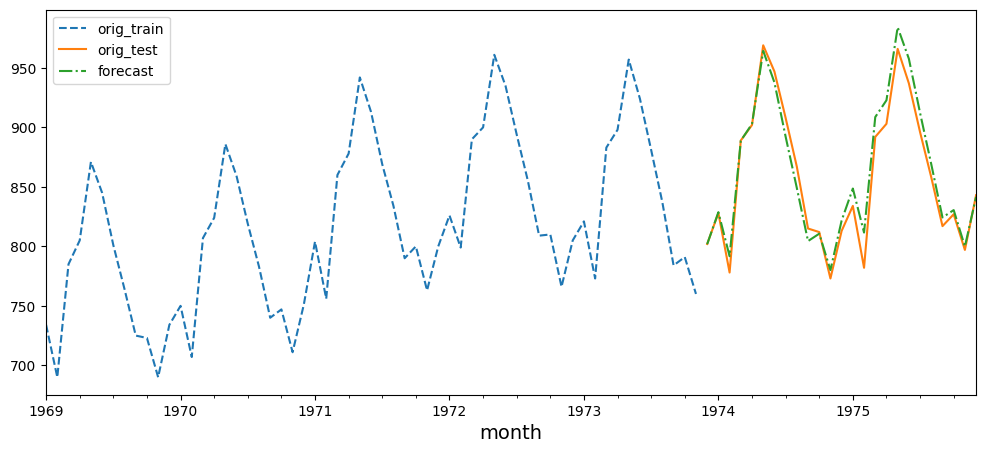

In [102]:
plot_forecast(milk_model, '1969', milk_train, milk_test);

In [124]:
from darts.models import ExponentialSmoothing
from darts import TimeSeries

ModuleNotFoundError: No module named 'darts'

## There is more

In [126]:
import darts
darts.__version__

ModuleNotFoundError: No module named 'darts'

In [44]:
model = ExponentialSmoothing(seasonal_periods=12)
ts = TimeSeries.from_dataframe(milk.reset_index(), 
                                    time_col='month', value_cols='production', freq='MS')
train, test = split_data(ts, 0.15)

train: 143 , test: 25


In [45]:
model.fit(train)
forecast = model.predict(len(test), num_samples=100)

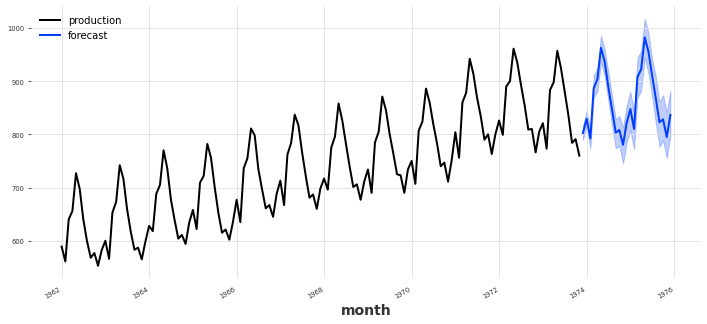

In [46]:
train.plot()
forecast.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
# plt.savefig('images/fig_10.9.png', bbox_inches='tight', dpi=300)

In [47]:
model.model.summary()

Dep. Variable:,endog,No. Observations:,143
Model:,ExponentialSmoothing,SSE,7265.655
Optimized:,True,AIC,593.714
Trend:,Additive,BIC,641.119
Seasonal:,Additive,AICC,599.230
Seasonal Periods:,12,Date:,"Mon, 06 Jun 2022"
Box-Cox:,False,Time:,01:19:48
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6859108,alpha,True
smoothing_trend,0.000000,beta,True


# Recipe 3. Forecasting Univariate Time Series Data with Non-Seasonal ARIMA

In [48]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
plt.rcParams["figure.figsize"] = [14, 4]  

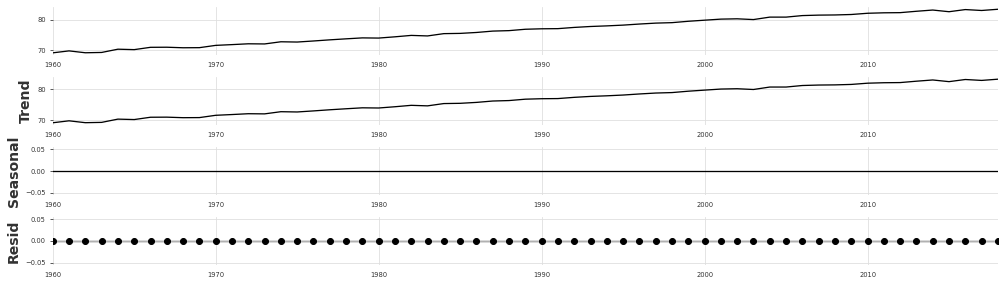

In [49]:
decomposed = seasonal_decompose(life)
decomposed.plot()
#plt.savefig('images/fig_10.10.png', bbox_inches='tight', dpi=300)
plt.show()

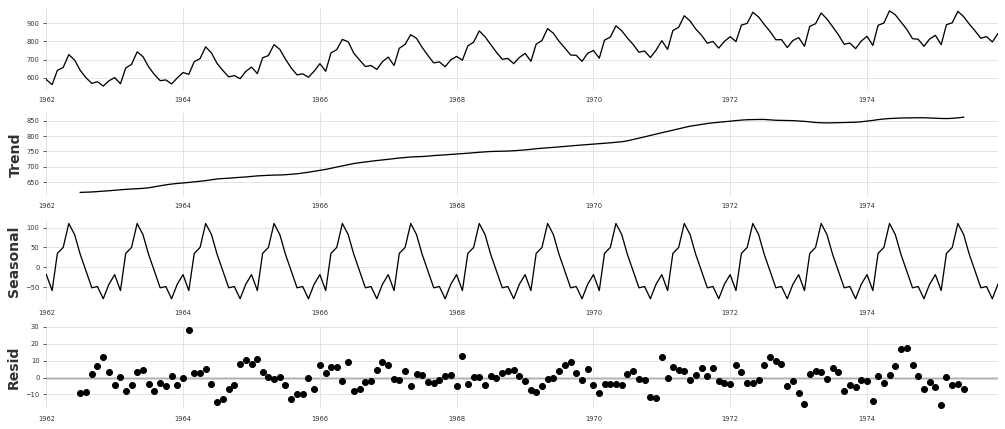

In [50]:
plt.rcParams["figure.figsize"] = [14, 6]  
decomposed = seasonal_decompose(milk, period=12)
decomposed.plot(); plt.show()

In [51]:
from pandas.plotting import autocorrelation_plot

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

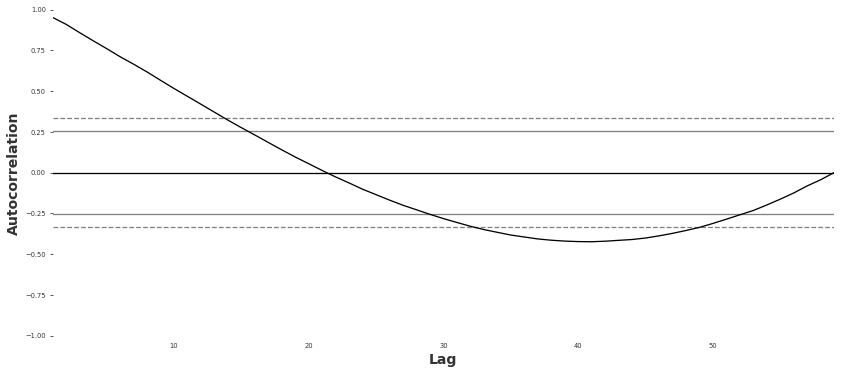

In [52]:
autocorrelation_plot(life)

In [53]:
check_stationarity(life)

'Non-Stationary	 p-value:0.6420882853800051 	 lags:2


('Non-Stationary', 0.6420882853800051)

In [54]:
life_df1 = life.diff().dropna()
check_stationarity(life_df1)

'Stationary	 p-value:1.556218967600307e-14 	 lags:1


('Stationary', 1.556218967600307e-14)

<AxesSubplot:xlabel='year'>

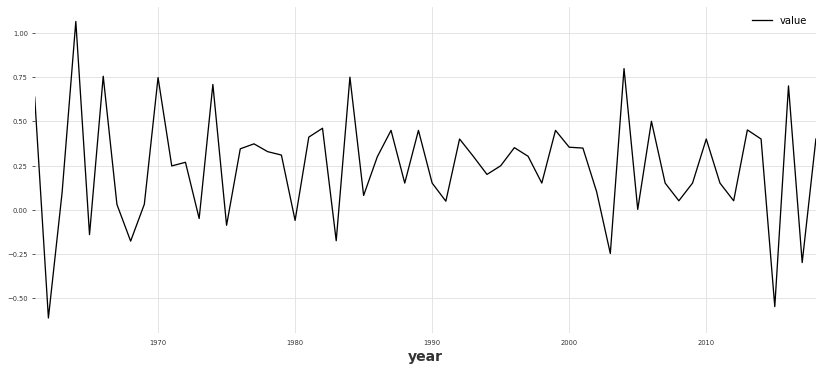

In [55]:
life_df1.plot()
#plt.savefig('images/fig_10.11.png', bbox_inches='tight', dpi=300)

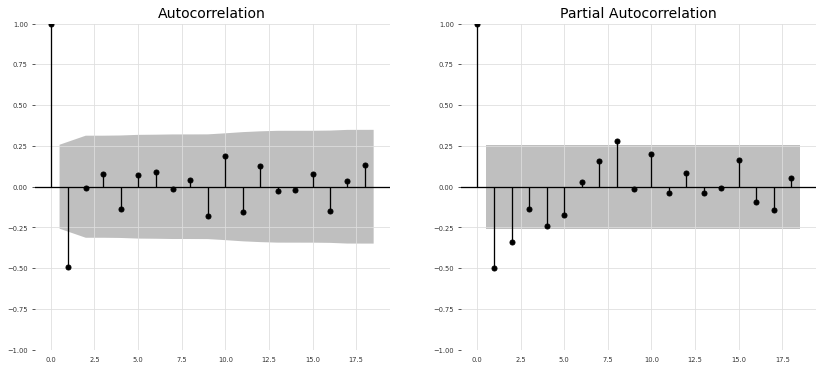

In [56]:
fig, ax = plt.subplots(1,2)
plot_acf(life_df1, ax=ax[0])
plot_pacf(life_df1, ax=ax[1])
#plt.savefig('images/fig_10.12.png', bbox_inches='tight', dpi=300)
plt.show()

In [57]:
(acorr_ljungbox(life_df1, 
                lags=25,
                return_df=True) < 0.05)['lb_pvalue'].sum()
# there is autocorrelation as we would expect 

24

In [58]:
model = ARIMA(life_train, order=(0,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   50
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -24.161
Date:                Mon, 06 Jun 2022   AIC                             52.321
Time:                        01:20:19   BIC                             56.105
Sample:                    01-01-1960   HQIC                            53.757
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0827      0.200      0.413      0.680      -0.310       0.475
sigma2         0.1569      0.032      4.918      0.000       0.094       0.219
===================================================================================
Ljung-Box (L1) (Q):                  12.54   Jarque-Bera (JB):                 0.56
Prob(Q):                              0.00   Prob(JB):                         0.76
Heteroskedasticity (H):               0.43   Skew:                             0.07
Prob(H) (two-sided):                  0.10   Kurtosis:                         3.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [59]:
(acorr_ljungbox(results.resid, 
                lags=25,
                return_df=True) < 0.05)['lb_pvalue'].sum()

0

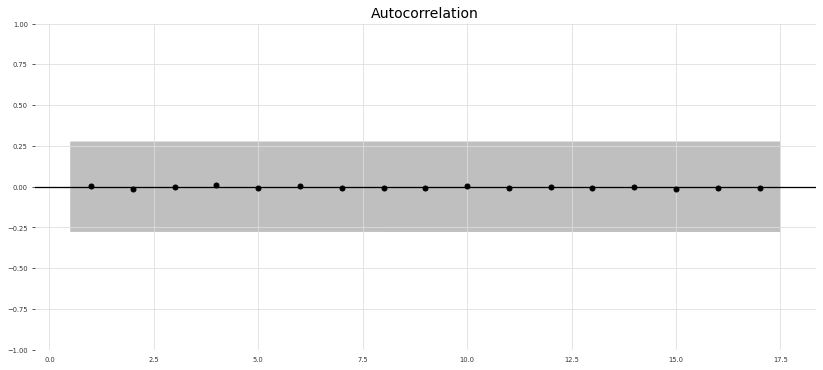

In [60]:
plot_acf(results.resid, zero=False);plt.show()

In [61]:
# from statsmodels.graphics.gofplots import qqplot

# pd.Series(results.resid).plot(kind='kde');plt.show()
# qqplot(results.resid, line='s'); plt.show()

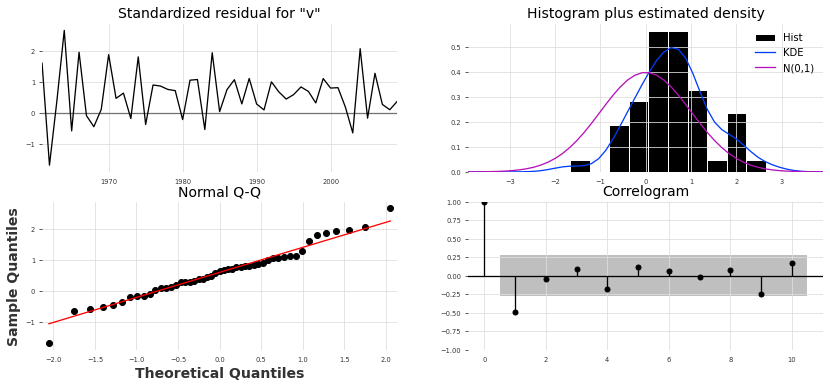

In [62]:
results.plot_diagnostics()
#plt.savefig('images/fig_10.15.png', bbox_inches='tight', dpi=300)
plt.show()

In [63]:
(acorr_ljungbox(results.resid, 
                lags=25,
                return_df=True) < 0.05)['lb_pvalue'].sum()

0

In [64]:
from scipy.stats import shapiro
shapiro(results.resid)[1] < 0.05

True

<AxesSubplot:xlabel='year'>

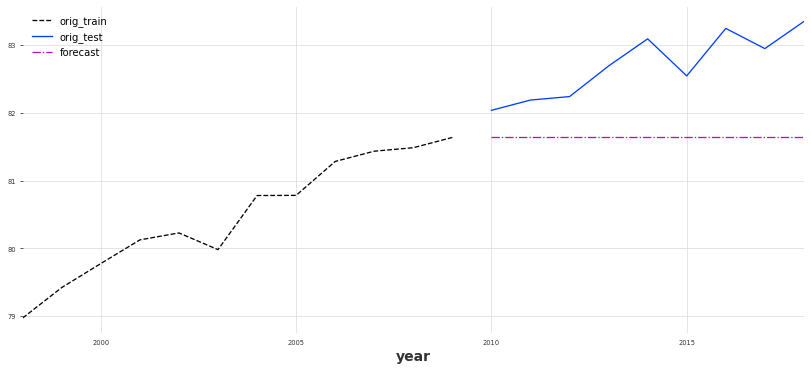

In [65]:
plot_forecast(results, '1998', life_train, life_test)

## There is more

In [66]:
pv, dv, qv = [list(range(3))]*3
vals = combinator([pv, dv, qv])
score = {}
for i, (p, d, q) in enumerate(vals):
    m = ARIMA(life_train, order=(p,d,q))
    res = m.fit()
    y = life_test.values.ravel() 
    y_hat = res.forecast(steps=len(y))
    score[i] = {'order': (p,d,q),
                'AIC':res.aic, 
                'BIC': res.bic,
                'AICc':res.aicc,
                'RMSPE': rmspe(y, y_hat),
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': res}

In [67]:
get_best_model(score, 'AIC')

Best model: 8 with lowest AIC score: 7.698477131195528


In [68]:
best_m = get_best_model(score, 'AIC')

Best model: 8 with lowest AIC score: 7.698477131195528


In [69]:
score[8]

{'order': (0, 2, 2),
 'AIC': 7.698477131195528,
 'BIC': 13.312080163919202,
 'AICc': 8.243931676650073,
 'RMSPE': 0.05593317584020921,
 'RMSE': 0.4633900097823148,
 'MAPE': 0.004491911001968695,
 'model': <statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x7fb866c44a60>}

In [70]:
score[4]['model'].model_orders

{'trend': 0,
 'exog': 0,
 'ar': 0,
 'ma': 1,
 'seasonal_ar': 0,
 'seasonal_ma': 0,
 'reduced_ar': 0,
 'reduced_ma': 1,
 'exog_variance': 0,
 'measurement_variance': 0,
 'variance': 1}

In [71]:
pd.DataFrame(score).T.sort_values(by='AIC').reset_index()

,index,order,AIC,BIC,AICc,RMSPE,RMSE,MAPE,model
0,8,"(0, 2, 2)",7.698477,13.31208,8.243932,0.055933,0.46339,0.004492,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
1,14,"(1, 1, 2)",9.5332,17.100481,10.442291,0.054759,0.453646,0.004395,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
2,17,"(1, 2, 2)",9.675778,17.160582,10.60601,0.055733,0.46173,0.00447,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
3,23,"(2, 1, 2)",11.509602,20.968704,12.904951,0.054477,0.451304,0.004365,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
4,26,"(2, 2, 2)",13.82939,23.185395,15.257962,0.074328,0.616145,0.006206,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
5,25,"(2, 2, 1)",19.674292,27.159096,20.604524,0.054421,0.451284,0.003984,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
6,16,"(1, 2, 1)",23.195622,28.809225,23.741077,0.048487,0.402034,0.003585,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
7,22,"(2, 1, 1)",25.291578,32.85886,26.200669,0.046799,0.388013,0.003499,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
8,7,"(0, 2, 1)",31.315044,35.057446,31.581711,0.047363,0.392699,0.003599,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
9,13,"(1, 1, 1)",33.424665,39.100125,33.957998,0.043381,0.359621,0.00338,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...


In [72]:
pd.DataFrame(score).T.sort_values(by='BIC').reset_index()

,index,order,AIC,BIC,AICc,RMSPE,RMSE,MAPE,model
0,8,"(0, 2, 2)",7.698477,13.31208,8.243932,0.055933,0.46339,0.004492,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
1,14,"(1, 1, 2)",9.5332,17.100481,10.442291,0.054759,0.453646,0.004395,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
2,17,"(1, 2, 2)",9.675778,17.160582,10.60601,0.055733,0.46173,0.00447,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
3,23,"(2, 1, 2)",11.509602,20.968704,12.904951,0.054477,0.451304,0.004365,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
4,26,"(2, 2, 2)",13.82939,23.185395,15.257962,0.074328,0.616145,0.006206,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
5,25,"(2, 2, 1)",19.674292,27.159096,20.604524,0.054421,0.451284,0.003984,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
6,16,"(1, 2, 1)",23.195622,28.809225,23.741077,0.048487,0.402034,0.003585,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
7,22,"(2, 1, 1)",25.291578,32.85886,26.200669,0.046799,0.388013,0.003499,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
8,7,"(0, 2, 1)",31.315044,35.057446,31.581711,0.047363,0.392699,0.003599,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
9,13,"(1, 1, 1)",33.424665,39.100125,33.957998,0.043381,0.359621,0.00338,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...


In [73]:
best_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   50
Model:                 ARIMA(0, 2, 2)   Log Likelihood                  -0.849
Date:                Mon, 06 Jun 2022   AIC                              7.698
Time:                        01:20:54   BIC                             13.312
Sample:                    01-01-1960   HQIC                             9.820
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.9475     20.438     -0.095      0.924     -42.005      38.110
ma.L2          0.9994     20.970      0.048      0.962     -40.101      42.100
sigma2         0.0497      1.044      0.048      0.962      -1.996       2.096
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):                 1.82
Prob(Q):                              0.58   Prob(JB):                         0.40
Heteroskedasticity (H):               0.38   Skew:                             0.17
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='year'>

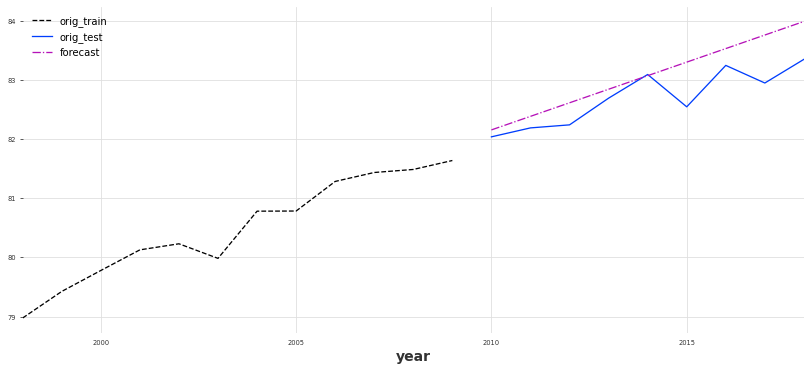

In [74]:
plot_forecast(best_m, '1998', life_train, life_test)

# Recipe 4. Forecasting Univariate Time Series Data with Seasonal ARIMA

In [75]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
plt.rcParams["figure.figsize"] = [14, 4]  

<AxesSubplot:xlabel='month'>

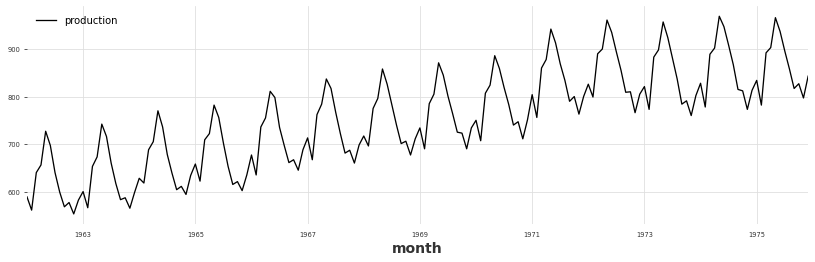

In [76]:
milk.plot()

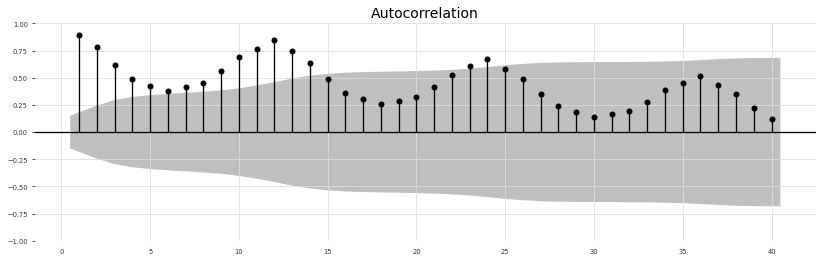

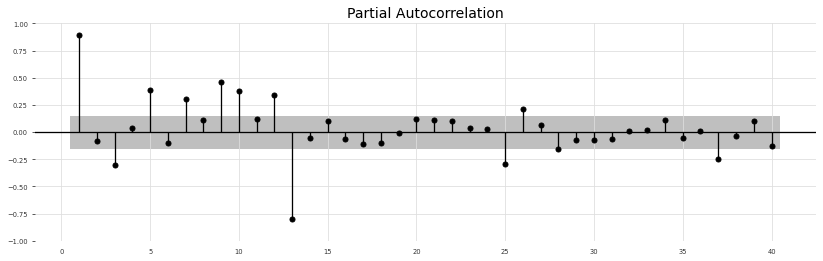

In [77]:
plot_acf(milk, lags=40, zero=False)
plot_pacf(milk, lags=40, zero=False);plt.show()

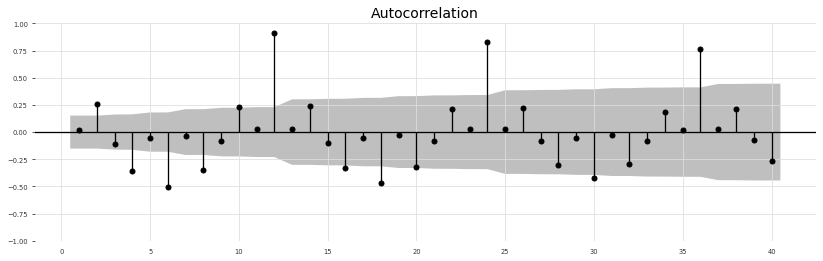

In [78]:
plot_acf(milk.diff(1).dropna(), lags=40, zero=False); plt.show()

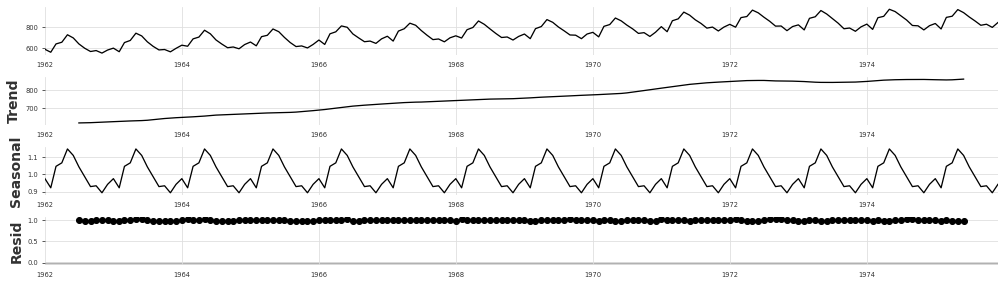

In [79]:
decomposed = seasonal_decompose(milk, period=12, model='multiplicative')
decomposed.plot(); plt.show()

In [80]:
milk_s = decomposed.seasonal

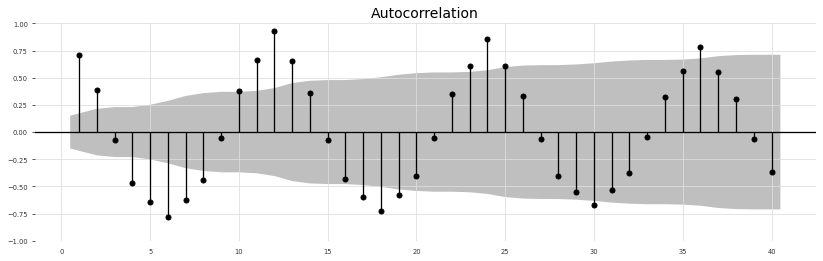

In [81]:
plot_acf(milk_s, zero=False, lags=40);plt.show()

In [82]:
milk_dif_12 = milk.diff(12).dropna()
milk_dif_12_1 = milk.diff(12).diff(1).dropna()

'Non-Stationary	 p-value:0.6274267086030308 	 lags:13
'Non-Stationary	 p-value:0.1607988052771142 	 lags:12
'Stationary	 p-value:1.865423431878921e-05 	 lags:11


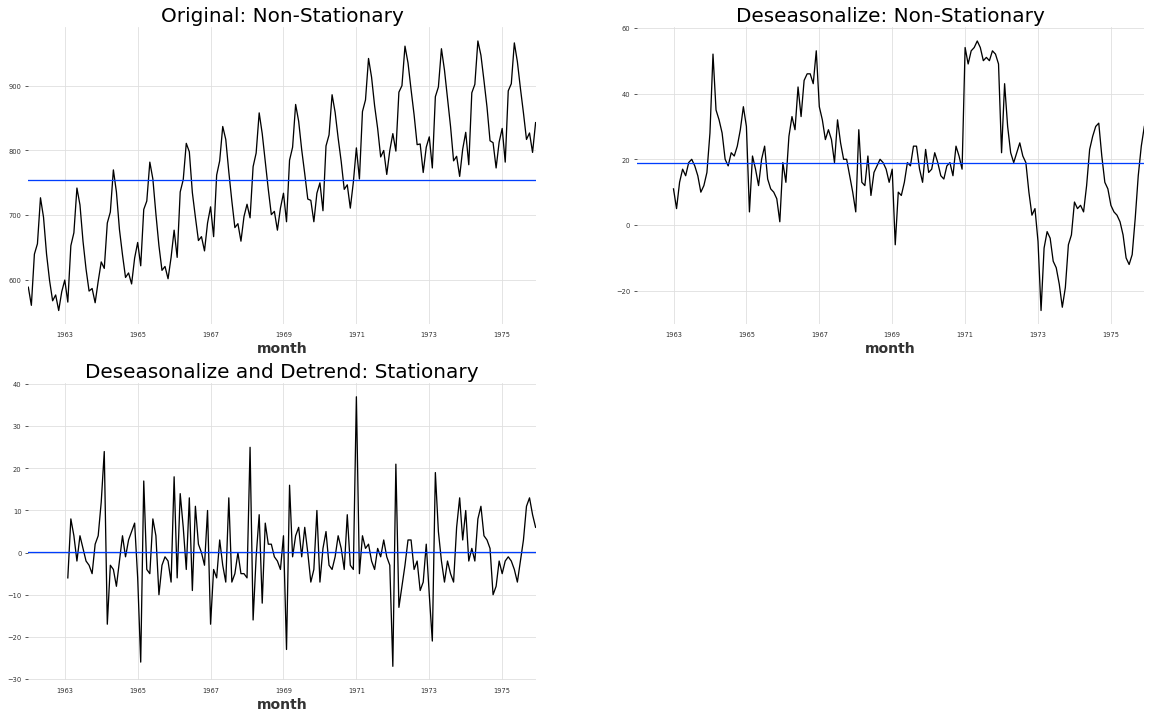

In [83]:
sets = [milk, milk_dif_12, milk_dif_12_1]
desc = ['Original', 'Deseasonalize', 'Deseasonalize and Detrend']
fig, ax = plt.subplots(2,2, figsize=(20,12))
index, l = milk.index, milk.shape[0]
for i, (d_set, d_desc) in enumerate(zip(sets, desc)):
    v, r = i // 2, i % 2
    outcome, pval = check_stationarity(d_set)
    d_set.plot(ax= ax[v,r], title=f'{d_desc}: {outcome}', legend=False)
    pd.Series(d_set.mean().values.tolist()*l, index=index).plot(ax=ax[v,r])
    ax[v,r].title.set_size(20)
ax[1,1].set_visible(False)
# plt.savefig('images/fig_10.21.png', bbox_inches='tight', dpi=300)
plt.show()

### How to Determine AR and MA terms

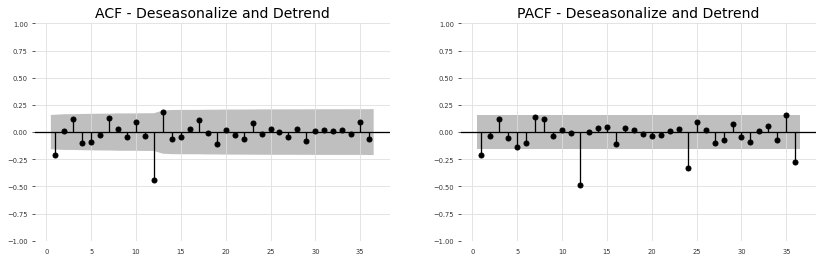

In [84]:
fig, ax = plt.subplots(1,2)
plot_acf(milk_dif_12_1, zero=False, lags=36, ax=ax[0], title=f'ACF - {d_desc}')
plot_pacf(milk_dif_12_1, zero=False, lags=36, ax=ax[1], title=f'PACF - {d_desc}')
plt.show()

[1, 12, 24, 36, 48]


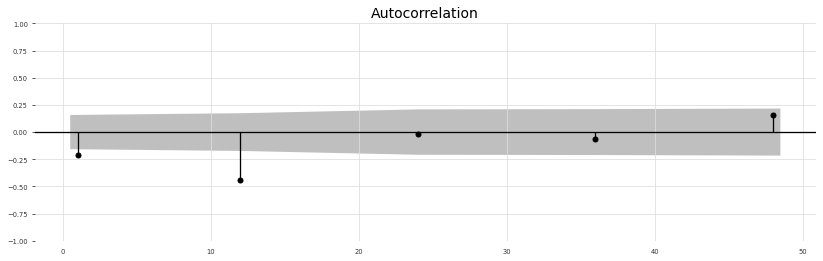

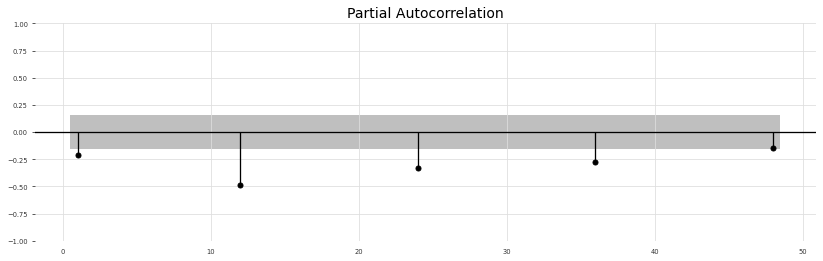

In [85]:
#lags = [1, 12, 24, 36, 48]
lags = [i for i in range(12, 60, 12)]
lags.insert(0, 1)
print(lags)
plot_acf(milk.diff(12).diff(1).dropna(),zero=False, lags=lags)
plot_pacf(milk.diff(12).diff(1).dropna(),zero=False, lags=lags);

### Fitting a SARIMA Model

In [86]:
sarima_model = SARIMAX(milk_train, 
                       order=(0,1,1),
                       seasonal_order=(0,1,1,12))
model = sarima_model.fit(disp=0)

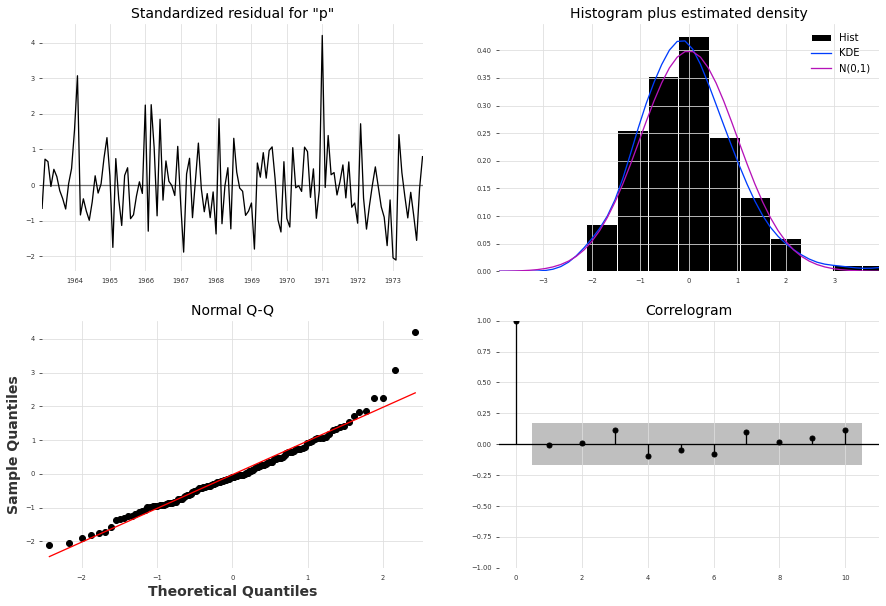

In [87]:
model.plot_diagnostics(figsize=(15,10))
# plt.savefig('images/fig_10.23.png', bbox_inches='tight', dpi=300)
plt.show()

In [88]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         production   No. Observations:                  143
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -448.668
Date:                            Mon, 06 Jun 2022   AIC                            903.335
Time:                                    01:21:39   BIC                            911.938
Sample:                                01-01-1962   HQIC                           906.831
                                     - 11-01-1973                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2811      0.084     -3.331      0.001      -0.446      -0.116
ma.S.L12      -0.6334      0.083     -7.653      0.000      -0.796      -0.471
sigma2        55.5239      5.753      9.650      0.000      44.247      66.800
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                35.77
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                             0.82
Prob(H) (two-sided):                  0.65   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='month'>

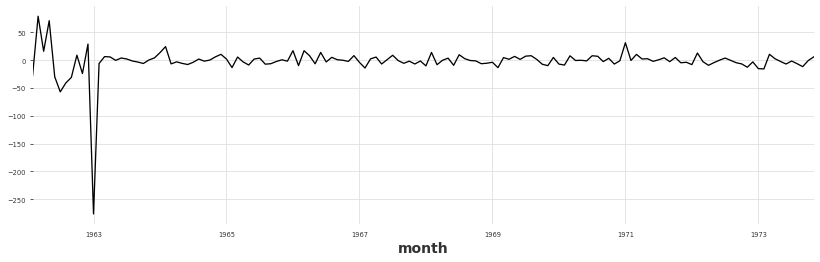

In [89]:
model.resid[1:].plot()

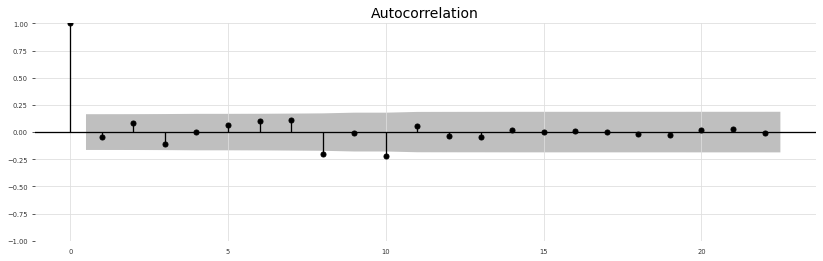

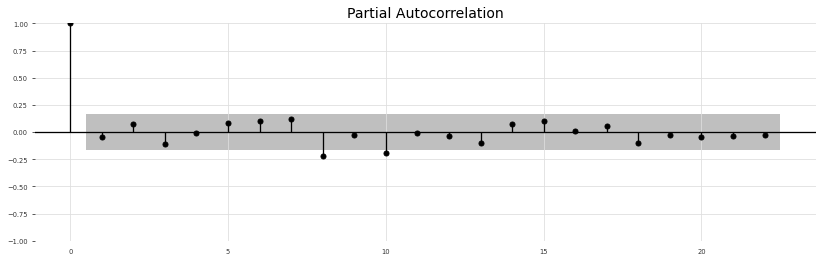

In [90]:
plot_acf(model.resid[1:])
plot_pacf(model.resid[1:]); plt.show()

<AxesSubplot:xlabel='month'>

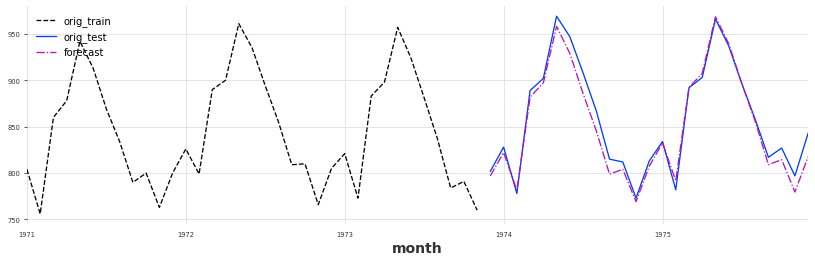

In [91]:
plot_forecast(model, '1971', milk_train, milk_test)
# plt.savefig('images/fig_10.24.png', bbox_inches='tight', dpi=300)

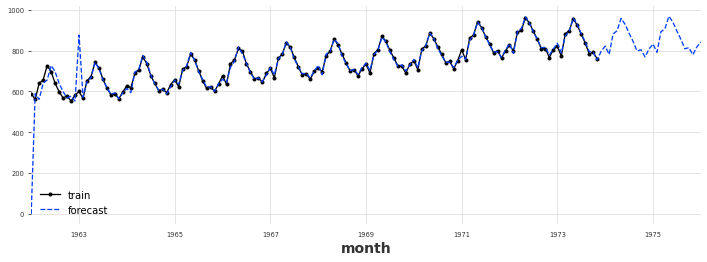

In [92]:
n = milk.shape[0]
milk_train.plot(style='.-', figsize=(12,4))
model.predict(end=n).plot(style='--')
plt.legend(['train', 'forecast'])

## There is more

In [93]:
%%time
P_ns, D_ns, Q_ns = [list(range(3))]*3
P_s, D_s, Q_s = [list(range(2))]*3

vals = combinator([P_ns, D_ns, Q_ns, P_s, D_s, Q_s])
score = {}
for i, (p, d, q, P, D, Q) in enumerate(vals):
    if i%15 == 0:
        print(f'Running model #{i} using SARIMA({p},{d},{q})({P},{D},{Q},12)')
    m = SARIMAX(milk_train, 
                order=(p,d,q),
                seasonal_order=(P, D, Q, 12),
                enforce_stationarity=False)
    res = m.fit(disp=0)
    y = milk_test.values.ravel() 
    y_hat = res.forecast(steps=len(y))
    score[i] = {'non-seasonal order': (p,d,q),
                'seasonal order': (P, D, Q),
                'AIC':res.aic, 
                'AICc': res.aicc,
                'BIC': res.bic,
                'RMSPE': rmspe(y, y_hat),
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': res}

Running model #0 using SARIMA(0,0,0)(0,0,0,12)
Running model #15 using SARIMA(0,0,1)(1,1,1,12)
Running model #30 using SARIMA(0,1,0)(1,1,0,12)
Running model #45 using SARIMA(0,1,2)(1,0,1,12)
Running model #60 using SARIMA(0,2,1)(1,0,0,12)
Running model #75 using SARIMA(1,0,0)(0,1,1,12)
Running model #90 using SARIMA(1,0,2)(0,1,0,12)
Running model #105 using SARIMA(1,1,1)(0,0,1,12)
Running model #120 using SARIMA(1,2,0)(0,0,0,12)
Running model #135 using SARIMA(1,2,1)(1,1,1,12)
Running model #150 using SARIMA(2,0,0)(1,1,0,12)
Running model #165 using SARIMA(2,0,2)(1,0,1,12)
Running model #180 using SARIMA(2,1,1)(1,0,0,12)
Running model #195 using SARIMA(2,2,0)(0,1,1,12)
Running model #210 using SARIMA(2,2,2)(0,1,0,12)
CPU times: user 54.3 s, sys: 1.39 s, total: 55.7 s
Wall time: 56.8 s


In [94]:
best_model = get_best_model(score, 'AIC')

Best model: 211 with lowest AIC score: 795.4217652843622


In [95]:
results = pd.DataFrame(score).T.sort_values(by='AIC').reset_index()
results.head(20)

,index,non-seasonal order,seasonal order,AIC,AICc,BIC,RMSPE,RMSE,MAPE,model
0,211,"(2, 2, 2)","(0, 1, 1)",795.421765,796.206812,811.838956,0.17819,15.135862,0.014454,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
1,67,"(0, 2, 2)","(0, 1, 1)",795.51592,795.882892,806.460713,0.328245,27.797614,0.028315,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
2,43,"(0, 1, 2)","(0, 1, 1)",796.763902,797.127539,807.743631,0.134089,11.487076,0.010387,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
3,187,"(2, 1, 2)","(0, 1, 1)",796.876071,797.653849,813.345664,0.12826,10.998609,0.010075,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
4,139,"(1, 2, 2)","(0, 1, 1)",797.117088,797.672643,810.79808,0.289728,24.535473,0.02477,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
5,191,"(2, 1, 2)","(1, 1, 1)",797.124136,798.170865,816.338661,0.111912,9.609455,0.009032,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
6,215,"(2, 2, 2)","(1, 1, 1)",797.419174,798.475778,816.572564,0.179478,15.243607,0.014577,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
7,115,"(1, 1, 2)","(0, 1, 1)",798.57341,799.123869,812.298071,0.1356,11.611922,0.010527,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
8,47,"(0, 1, 2)","(1, 1, 1)",798.638183,799.188641,812.362843,0.133006,11.396142,0.010312,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
9,71,"(0, 2, 2)","(1, 1, 1)",798.88124,799.436795,812.562232,0.427692,36.195046,0.03686,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


In [96]:
results = pd.DataFrame(score).T.sort_values(by='BIC').reset_index()
results.head(20)

,index,non-seasonal order,seasonal order,AIC,AICc,BIC,RMSPE,RMSE,MAPE,model
0,67,"(0, 2, 2)","(0, 1, 1)",795.51592,795.882892,806.460713,0.328245,27.797614,0.028315,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
1,43,"(0, 1, 2)","(0, 1, 1)",796.763902,797.127539,807.743631,0.134089,11.487076,0.010387,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
2,35,"(0, 1, 1)","(0, 1, 1)",802.462674,802.676959,810.723444,0.13409,11.489678,0.01037,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
3,139,"(1, 2, 2)","(0, 1, 1)",797.117088,797.672643,810.79808,0.289728,24.535473,0.02477,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
4,211,"(2, 2, 2)","(0, 1, 1)",795.421765,796.206812,811.838956,0.17819,15.135862,0.014454,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
5,115,"(1, 1, 2)","(0, 1, 1)",798.57341,799.123869,812.298071,0.1356,11.611922,0.010527,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
6,47,"(0, 1, 2)","(1, 1, 1)",798.638183,799.188641,812.362843,0.133006,11.396142,0.010312,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
7,71,"(0, 2, 2)","(1, 1, 1)",798.88124,799.436795,812.562232,0.427692,36.195046,0.03686,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
8,187,"(2, 1, 2)","(0, 1, 1)",796.876071,797.653849,813.345664,0.12826,10.998609,0.010075,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
9,131,"(1, 2, 1)","(0, 1, 1)",802.770371,803.134007,813.7501,0.20581,17.449873,0.016939,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


In [97]:
score[211]

{'non-seasonal order': (2, 2, 2),
 'seasonal order': (0, 1, 1),
 'AIC': 795.4217652843622,
 'AICc': 796.2068120133342,
 'BIC': 811.8389559747292,
 'RMSPE': 0.17818990207115598,
 'RMSE': 15.135861916002764,
 'MAPE': 0.014454262783870993,
 'model': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7fb7f22d9df0>}

<AxesSubplot:xlabel='month'>

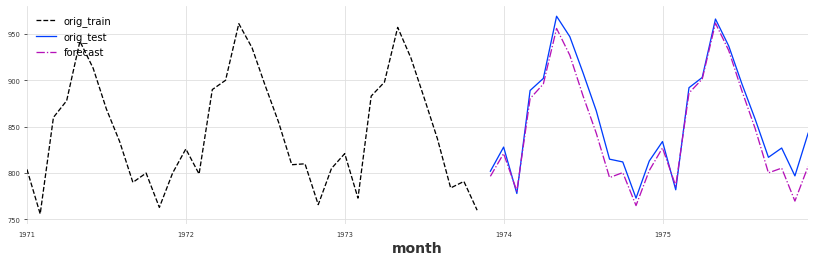

In [98]:
plot_forecast(best_model, '1971', milk_train, milk_test)
# plt.savefig('images/fig_10.25.png', bbox_inches='tight', dpi=300)